In [25]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import torch
import glob
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import torch.nn.functional as F
from torchmetrics.detection import MeanAveragePrecision
from torchvision.transforms import transforms as T
import torchvision
from tqdm import tqdm

In [27]:
import sys
sys.path.append('/usr/users/vogg/monkey-tracking-in-the-wild/src/lib/')
sys.path.insert(0, '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages')

from models.model import create_model, load_model
import datasets.dataset as dataset
from models.decode import mot_decode, _topk, map2orig

#### Load model

In [13]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids_roi_only_gc_80_1e-5/model_50.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids_roi_only_gc_80_1e-5/model_50.pth, epoch 50


#### Load data

In [5]:
dset = dataset.ImageLabelDataset(
    root='/usr/users/agecker/datasets/lemur_ids/',
    file_list='/usr/users/vogg/monkey-tracking-in-the-wild/src/data/lemur_ids.train',
    resize=True
    )

In [6]:
class_names = ['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red', 'Uns']

In [8]:
# path = "/usr/users/agecker/datasets/lemur_ids"

# dataloader = dataset.LoadImagesAndBoxes(path, 
#                                          "/usr/users/weis4/code/monkey_tracking/monkey-tracking-in-the-wild/src/data/lemur_ids.val",
#                                         valset='lemur_ids',
#                                         img_size=(1088, 608))

#### Run evaluation for detections

In [9]:
df = pd.DataFrame(columns = ['model', 'valset', 'seed', 'AP', 'AP50', 'AP75'])

mean_ap = MeanAveragePrecision()
for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)

    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4


    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    dets_bbox = torch.from_numpy(np.concatenate([*dets.values()]))
    dets_class = torch.cat([torch.zeros(len(dets[0])), torch.ones(len(dets[1]))])

    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) #* np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")

    mean_ap.update(
        [dict(boxes=dets_bbox[:, :4], scores=dets_bbox[:, 4], labels=dets_class)],
        [dict(boxes=gt_bbox, labels=torch.from_numpy(labels[:, 0]))],
    )

100%|██████████| 315/315 [00:56<00:00,  5.55it/s]


In [10]:
scores = mean_ap.compute()
mdl = 'test1'
valset = 'lemur_id_train'
seed = 0
print({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'], 'AP50': scores['map_50'], 'AP75': scores['map_75']})
df = pd.concat([df, pd.DataFrame({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'].numpy(), 'AP50': scores['map_50'].numpy(), 'AP75': scores['map_75'].numpy()}, index = [0])])

/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/torchmetrics/detection/mean_ap.py:459: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  gt_label_mask = (self.groundtruth_labels[idx] == class_id).nonzero().squeeze(1)


{'model': 'test1', 'valset': 'lemur_id_train', 'seed': 0, 'AP': tensor(0.5028), 'AP50': tensor(0.7123), 'AP75': tensor(0.5593)}


In [11]:
color_dict = {
    0: (255, 0, 0),
    1: (255, 255, 0),
}

def plotBBox(image, bboxes, labels, colors=color_dict):
    
    image = image.copy()

    for i in range(len(bboxes)):
        low_left = np.array([bboxes[i, 0], bboxes[i, 1]]).astype(int)
        up_right = np.array([bboxes[i, 2], bboxes[i, 3]]).astype(int)

        image = cv2.rectangle(image, low_left, up_right, color=color_dict[labels[i]], thickness = 5)

    return image #cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
img0 = np.moveaxis(image, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

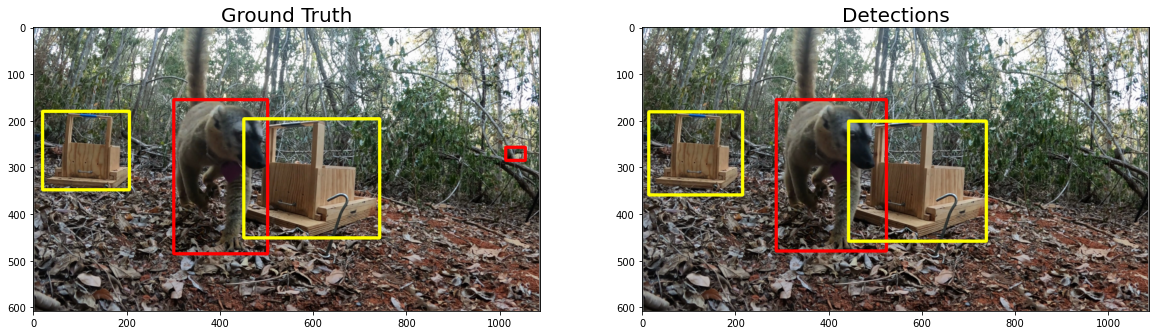

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[1].imshow(plotBBox(img0, dets_bbox, dets_class.numpy()))
ax[0].imshow(plotBBox(img0, gt_bbox, labels[:, 0]))

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

#### Lemur ID classification

In [14]:
def plot_bbox_w_id(image, bboxes):
    
    image = image.copy()

    coords = []
    for i in range(len(bboxes)):
        up_left = np.array([bboxes[i, 0], bboxes[i, 1]]).astype(int)
        low_right = np.array([bboxes[i, 2], bboxes[i, 3]]).astype(int)

        image = cv2.rectangle(image, up_left, low_right, color=(255, 255, 0), thickness = 5)
        coords.append(up_left)

    return image, coords #cv2.cvtColor(image, cv2.COLOR_BGR2RGB), coords

In [15]:
labels_lemurs = labels[labels[:, 0]==0]
bboxes_lemurs = gt_bbox[labels[:, 0]==0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

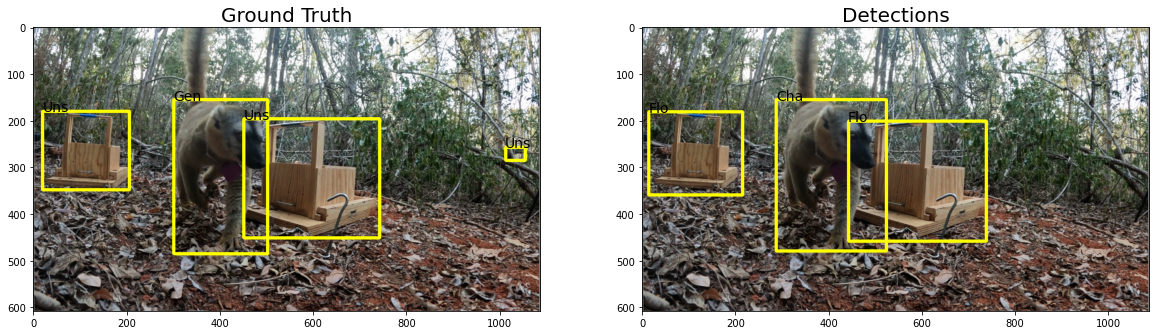

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

image, coords = plot_bbox_w_id(img0, gt_bbox)
image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax[0].imshow(image)
ax[1].imshow(image2)

for i, c in enumerate(coords):
    ax[0].annotate(class_names[int(labels[i, -1])], c, fontsize=14)
    
for i, c in enumerate(coords2):
    ax[1].annotate(class_names[int(dets_class[i])], c, fontsize=14)

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

In [9]:
df = pd.DataFrame(columns = ['model', 'valset', 'seed', 'AP', 'AP50', 'AP75'])


mean_ap = MeanAveragePrecision()

for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = image.shape[1]
    height = image.shape[0]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4


    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)
        
        # Spatial indices of lemur detections
        lemur_detect_inds = inds[:, cls_inds_mask[0]]

        # Id classification logits per lemur detection
        cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu()

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    # Only keep lemur predictions.
    dets = dets[0]

    dets_bbox = torch.from_numpy(dets)
    dets_class = torch.argmax(cls_logits, dim=1)
    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Id classification logits per lemur detection
#     cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda()]).cpu()
#     dets_class = torch.argmax(cls_logits, dim=1)

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6])# * np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")

    mean_ap.update(
        [dict(boxes=dets_bbox[:, :4], scores=dets_bbox[:, 4], labels=dets_class)],
        [dict(boxes=gt_bbox, labels=torch.from_numpy(labels[:, -1]))],
    )

  0%|          | 0/315 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 2

In [25]:
scores = mean_ap.compute()
mdl = 'test1'
valset = 'lemur_id_train'
seed = 0
print({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'], 'AP50': scores['map_50'], 'AP75': scores['map_75']})
df = pd.concat([df, pd.DataFrame({'model': mdl, 'valset': valset, 'seed': seed, 
          'AP': scores['map'].numpy(), 'AP50': scores['map_50'].numpy(), 'AP75': scores['map_75'].numpy()}, index = [0])])

/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/torchmetrics/detection/mean_ap.py:459: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  gt_label_mask = (self.groundtruth_labels[idx] == class_id).nonzero().squeeze(1)


{'model': 'test1', 'valset': 'lemur_id_train', 'seed': 0, 'AP': tensor(0.4739), 'AP50': tensor(0.6574), 'AP75': tensor(0.5875)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Ground Truth')

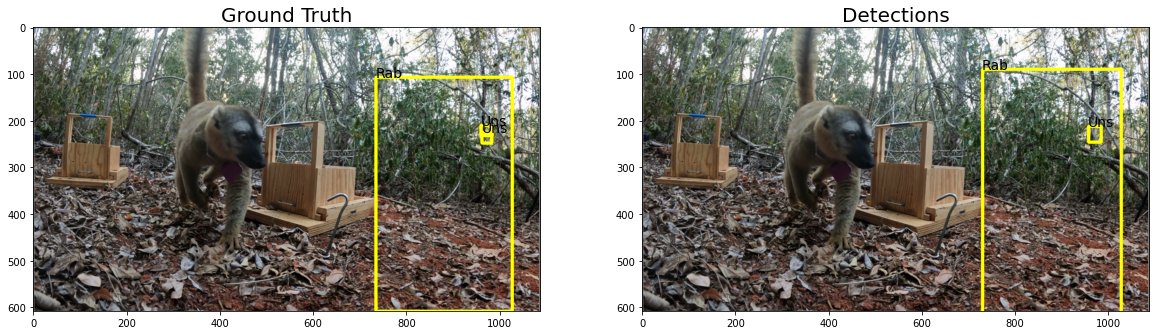

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

image, coords = plot_bbox_w_id(img0, gt_bbox)
image2, coords2 = plot_bbox_w_id(img0, dets_bbox)

ax[0].imshow(image)
ax[1].imshow(image2)

for i, c in enumerate(coords):
    ax[0].annotate(class_names[int(labels[i, -1])], c, fontsize=14)
    
for i, c in enumerate(coords2):
    ax[1].annotate(class_names[int(dets_class[i])], c, fontsize=14)

ax[1].set_title('Detections', fontsize=20)
ax[0].set_title('Ground Truth', fontsize=20)

In [23]:
dets_class

tensor([2, 7])

In [24]:
labels[:, -1]

array([7., 2.])

#### Match objects

In [11]:
from scipy.optimize import linear_sum_assignment

In [17]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = False)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids/model_6.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids/model_6.pth, epoch 6


In [12]:
accuracy = 0
count = 0
for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4



    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)
        
        # Spatial indices of lemur detections
        lemur_detect_inds = inds[:, cls_inds_mask[0]]

        # Id classification logits per lemur detection
        cls_logits = model.gc_lin(output['gc'], lemur_detect_inds).cpu().numpy()

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    # Only keep lemur predictions.
    dets_bbox = dets[0]
    dets_class = np.argmax(cls_logits, axis=1)

    remain_inds = dets_bbox[:, 4] > 0.1
    dets_bbox = dets_bbox[remain_inds]
    dets_class = dets_class[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
#     gt_bbox = torchvision.ops.box_convert(gt_bbox, "cxcywh", "xyxy")
    
#     assert gt_bbox.size(0) == 1
    
    iou_matrix = torchvision.ops.box_iou(gt_bbox, torch.from_numpy(dets_bbox[:, :4])).numpy()
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    accuracy += (dets_class[col_ind] == labels[:, -1][row_ind]).sum()
    count += len(labels[:, -1])

accuracy /= count

  0%|          | 0/315 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 2

In [19]:
accuracy

0.8037542662116041

### ROI

In [31]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2, 'gc': 128}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = True)

print(os.getcwd())
model = load_model(model, '../exp/mot/lemur_ids_roi_only_gc_80_1e-5/model_150.pth')
model = model.to(torch.device('cuda'))
model.eval();

/usr/users/vogg/monkey-tracking-in-the-wild/notebooks
loaded ../exp/mot/lemur_ids_roi_only_gc_80_1e-5/model_150.pth, epoch 150


In [32]:
accuracy = 0
count = 0


for i in tqdm(range(dset.__len__())):
# for i, (img_path, img, img0, labels) in tqdm(enumerate(dataloader)):
    
    image, img_path, original_shape, labels = dset.__getitem__(i)
    im_blob = torch.from_numpy(image).cuda().unsqueeze(0)

    width = im_blob.shape[3]
    height = im_blob.shape[2]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    h_out = inp_height // 4
    w_out = inp_width // 4



    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']
        
        num_classes = hm.size(1)

        dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                           wh=wh,
                                           reg=reg,
                                           num_classes=num_classes,
                                           cat_spec_wh=False,
                                           K=50)

    # Translate and scale bounding box detections.
    dets = map2orig(dets, h_out, w_out, height, width, num_classes)
    
    # Only keep lemur predictions.
    dets = dets[0]
    dets_bbox = torch.from_numpy(dets)
    remain_inds = dets_bbox[:, 4] > 0.01
    dets_bbox = dets_bbox[remain_inds]
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Id classification logits per lemur detection
    cls_logits = model.gc_lin(output['gc'], bboxes=[dets_bbox[:, :4].cuda() / 4]).cpu()
    dets_class = torch.argmax(cls_logits, dim=1)
    
    # Only keep lemur ground truth boxes.
    labels = labels[labels[:, 0]==0]

    # Translate and scale ground truth bounding boxes.
    gt_bbox = torch.Tensor(labels[:, 2:6]) # * np.array([width, height, width, height]))
   
    assert gt_bbox.size(0) > 0

    iou_matrix = torchvision.ops.box_iou(gt_bbox, dets_bbox[:, :4]).numpy()
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    accuracy += (dets_class[col_ind].numpy() == labels[:, -1][row_ind]).sum()
    count += len(labels[:, -1])
    
    

accuracy /= count

100%|██████████| 315/315 [00:27<00:00, 11.56it/s]


In [30]:
accuracy

0.5580204778156996

In [24]:
image.shape

(3, 608, 1088)